In [ ]:
!pip install scikit-image


In [ ]:
from google.colab import files
from PIL import Image, ImageFilter
import torchvision.transforms as transforms
import numpy as np

# Upload image
uploaded = files.upload()
img_path = list(uploaded.keys())[0]

# Load and prepare image
img = Image.open(img_path).convert('RGB').resize((128, 128))
transform = transforms.ToTensor()
img_tensor = transform(img).unsqueeze(0)  # [1, 3, 128, 128]

# Simulate blur
blurred_img = img.filter(ImageFilter.GaussianBlur(radius=2))
blurred_tensor = transform(blurred_img).unsqueeze(0)


Saving 7_NIKON-D3400-35MM_F.JPG to 7_NIKON-D3400-35MM_F (1).JPG


In [ ]:
import torch
import torch.nn as nn

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, 3, stride=2, padding=1), nn.ReLU(),
            nn.Conv2d(64, 128, 3, stride=2, padding=1), nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1), nn.ReLU(),
            nn.ConvTranspose2d(64, 3, 3, stride=2, padding=1, output_padding=1), nn.Sigmoid()
        )

    def forward(self, x):
        return self.decoder(self.encoder(x))


In [ ]:
model = Autoencoder()  # using CPU
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

epochs = 1000
for epoch in range(epochs):
    output = model(blurred_tensor)
    loss = criterion(output, img_tensor)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.6f}")


Epoch 0, Loss: 0.116140
Epoch 100, Loss: 0.008358
Epoch 200, Loss: 0.006460
Epoch 300, Loss: 0.006144
Epoch 400, Loss: 0.005344
Epoch 500, Loss: 0.005046
Epoch 600, Loss: 0.004624
Epoch 700, Loss: 0.004391
Epoch 800, Loss: 0.004203
Epoch 900, Loss: 0.004074


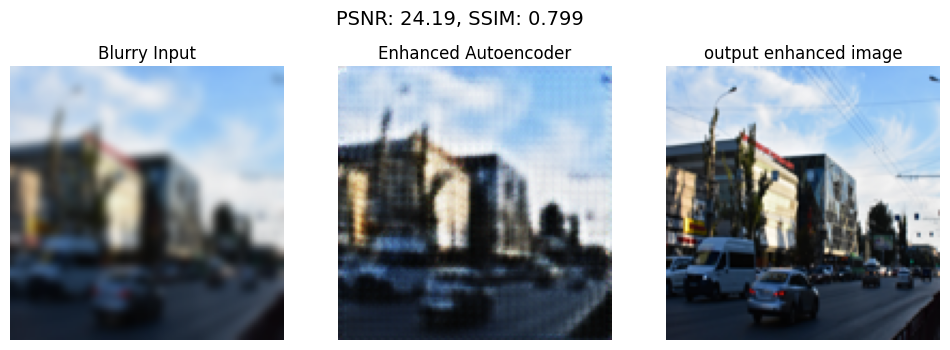

In [ ]:
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio as psnr, structural_similarity as ssim

# Convert to NumPy
original_np = img_tensor.squeeze().permute(1, 2, 0).detach().numpy()
blurred_np = blurred_tensor.squeeze().permute(1, 2, 0).detach().numpy()
enhanced_np = output.detach().squeeze().permute(1, 2, 0).numpy()

# Metrics
psnr_val = psnr(original_np, enhanced_np)
ssim_val = ssim(original_np, enhanced_np, channel_axis=2,data_range=1.0)

# Plot results
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.imshow(blurred_np)
plt.title("Blurry Input")
plt.axis("off")

plt.subplot(1,3,2)
plt.imshow(enhanced_np)
plt.title("Enhanced Autoencoder")
plt.axis("off")

plt.subplot(1,3,3)
plt.imshow(original_np)
plt.title("output enhanced image")
plt.axis("off")

plt.suptitle(f"PSNR: {psnr_val:.2f}, SSIM: {ssim_val:.3f}", fontsize=14)
plt.show()
